# Respostas - Lista 1 - Visão Computacional 
Alunos:


# Questão 1

Importando as bibliotecas e carregando as imagens em preto e branco.
img1 : imagem do background
img2 : background + foreground

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img1 = cv2.imread('imgs/first_frame.jpg',0)
img2 = cv2.imread('imgs/second_frame.jpg',0)

Primeiro, moldamos a img2 para ficar com o mesmo tamanho da img1.

Para **subsampling**, deve-se borrar a imagem um pouco para poder dar resize, para haver menor perda de informação.

In [3]:
KERNEL_SIZE = 1
img2_blur = cv2.GaussianBlur(img2, (KERNEL_SIZE, KERNEL_SIZE), 0)
width, height = img1.shape[1], img1.shape[0]

img2_resized = cv2.resize(img2_blur, (width, height), 
                          interpolation= cv2.INTER_CUBIC)

Pegamos a diferença absoluta entre as imagens para destacar as diferenças.

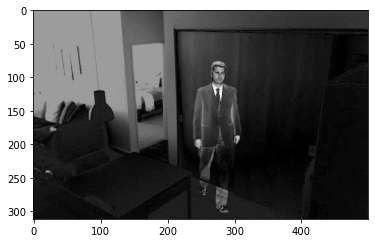

In [4]:
absdiff = cv2.absdiff(img2_resized, img1)
plt.imshow(absdiff, cmap='gray')


Aplicamos um threshold para obter melhor detalhe

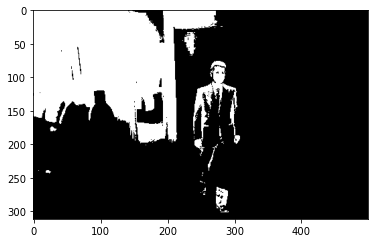

In [5]:
_,thr = cv2.threshold(absdiff,127,255,cv2.THRESH_OTSU)
plt.imshow(thr, cmap='gray')

E restaura-se parte da imagem do threshold.

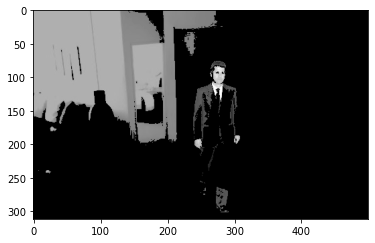

In [6]:
foreground = np.zeros_like(thr)
for i in range(thr.shape[0]):
    for j in range(thr.shape[1]):
        if thr[i,j] > 127:
            foreground[i,j] = img2_resized[i,j]
        else:
            foreground[i,j] = thr[i,j]
plt.imshow(foreground, cmap='gray')

# Questão 2
Destacar o foreground

# Questão 3
Aplicação para fazer convolução em imagem

In [7]:
def convolvefilter(img, kernel):

    if kernel.shape[0] != kernel.shape[1]:
        return "Kernel must be size n x n. "
    if kernel.shape[0] %2 == 0 and kernel.shape[0] != 1:
        return "Kernel n lines and columns must be odd. "
    
    # n lines and columns of kernel
    img = img * 1.0
    n = kernel.shape[0]
    # size of border
    border_rad = int(n/2)
    
    # Transformando em um filtro para convolução
    KERNEL_conv = np.fliplr(np.flipud(kernel))

    finalMatrix = np.zeros_like(img)

    # Considerando as bordas do canvas = 0
    canvas = np.zeros((img.shape[0] + (n-1), img.shape[1] + (n-1)))
    canvas[border_rad:img.shape[0] + border_rad, border_rad:img.shape[1] + border_rad] = img

    width, height = img.shape[1], img.shape[0]
    # Aplicando o filtro na imagem
    for x in range(width):
        for y in range(height):
            # Propriamente a convolução
            finalMatrix[y,x]=(KERNEL_conv * canvas[y: y+n, x: x+n]).sum()
    
    # Para salvar a imagem:
    # cv2.imwrite('./result.jpg', finalMatrix)
    return finalMatrix

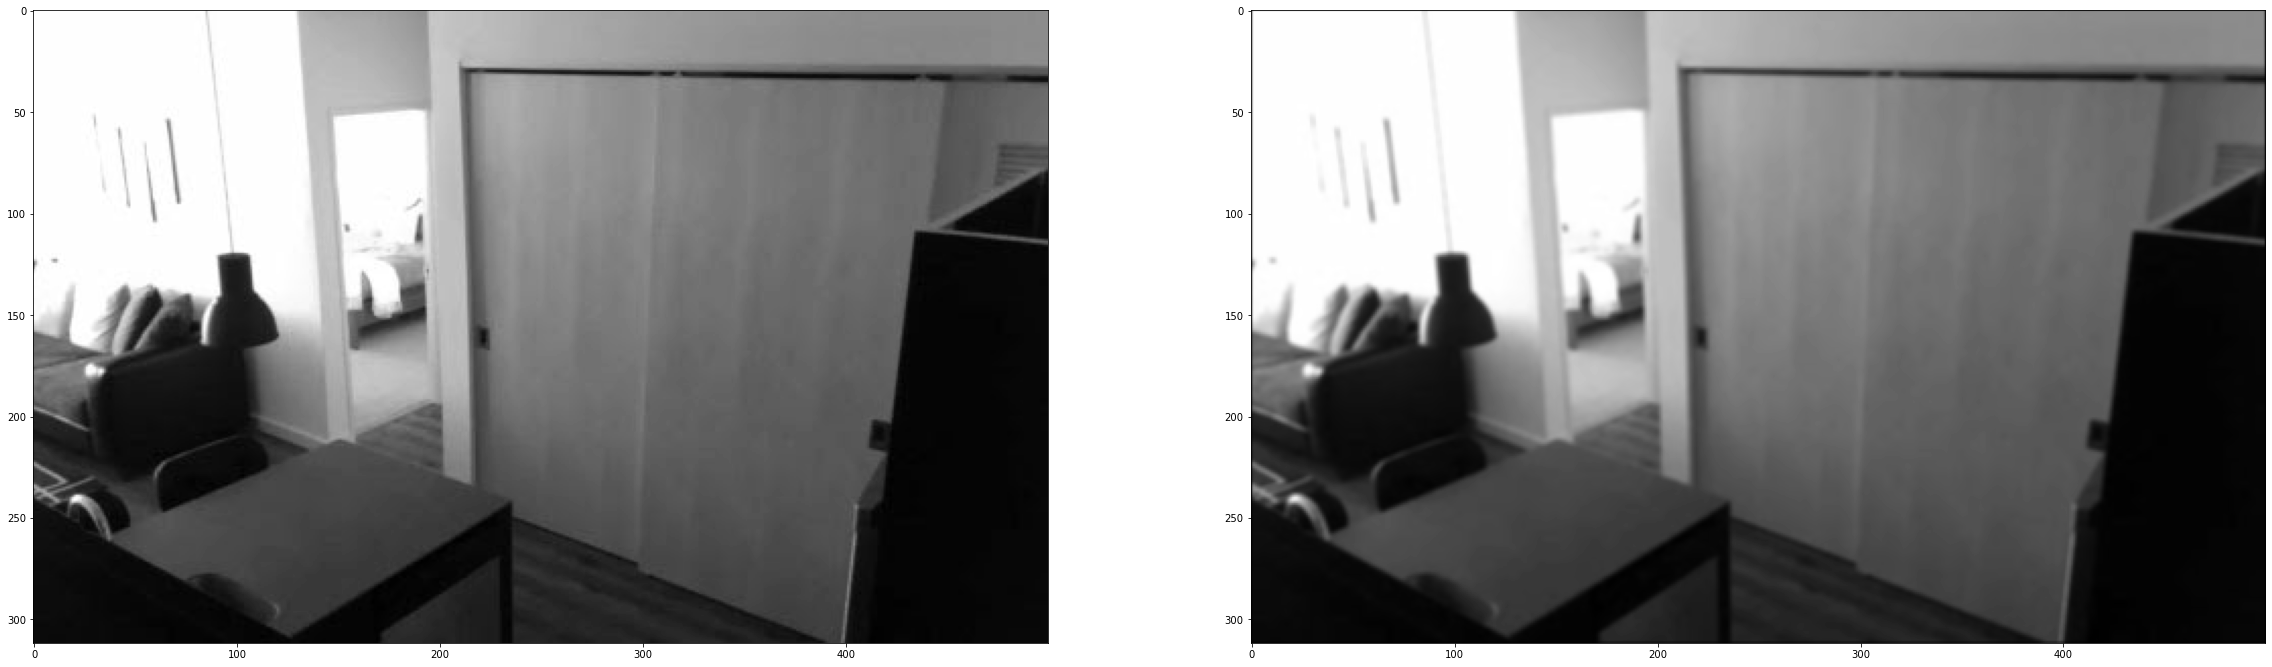

In [8]:
blur_box = np.array([[1,1,1],
                     [1,1,1],
                     [1,1,1]])*(1/9)
blur_img = convolvefilter(img1, blur_box)

f, axis = plt.subplots(1,2,figsize=(40,25))
axis[0].imshow(img1,cmap='gray')
axis[1].imshow(blur_img,cmap='gray')


# Questão 4
Filtros para remoção de ruídos

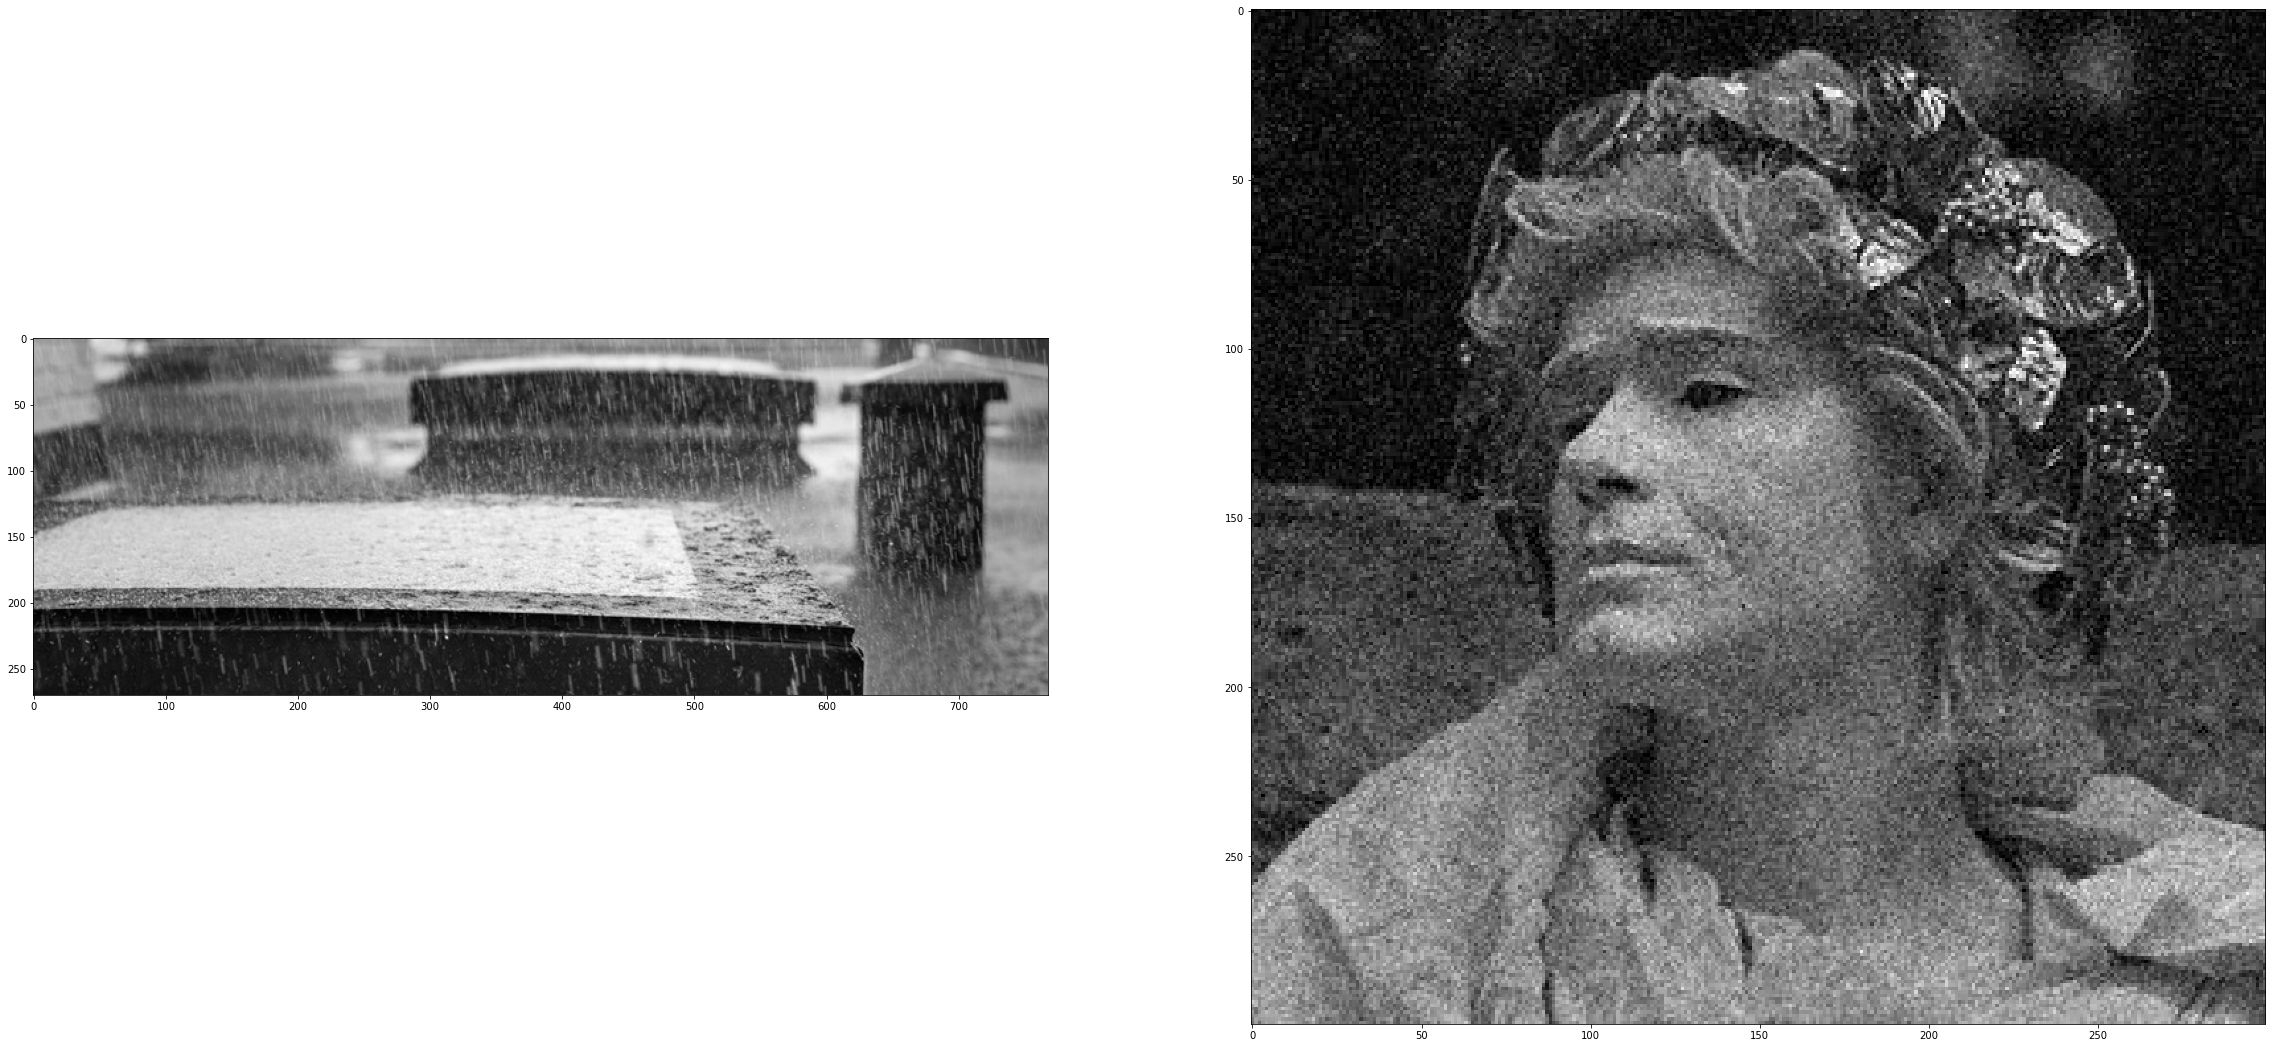

In [9]:
noise_1 = cv2.imread('imgs/rain_noise.jpg', 0)
noise_2= cv2.imread('imgs/statue_noise.jpg', 0)

f, axis = plt.subplots(1,2,figsize=(40,25))
axis[0].imshow(noise_1, cmap='gray')
axis[1].imshow(noise_2, cmap='gray')

In [10]:
def noiseReductionMedianFilter(img, n):
    """
    n : size of kernel
    """
    if n % 2 == 0:
        return 'Kernel dimensions must be odd. '
    
    # n lines and columns of kernel
    # size of border
    border_rad = int(n/2)
    
    # Transformando em um filtro para convolução
    KERNEL_conv = np.zeros_like((n,n))

    finalMatrix = np.zeros_like(img)

    # Considerando as bordas do canvas = 0
    canvas = np.zeros((img.shape[0] + (n-1), img.shape[1] + (n-1)))
    canvas[border_rad:img.shape[0] + border_rad, border_rad:img.shape[1] + border_rad] = img

    width, height = img.shape[1], img.shape[0]
    # Aplicando o filtro na imagem
    for x in range(width):
        for y in range(height):
            # Propriamente a convolução por mediana dos pixels da matriz
            KERNEL_conv = np.median(canvas[y: y+n, x:x+n])
            finalMatrix[y,x] = KERNEL_conv
    
    return finalMatrix


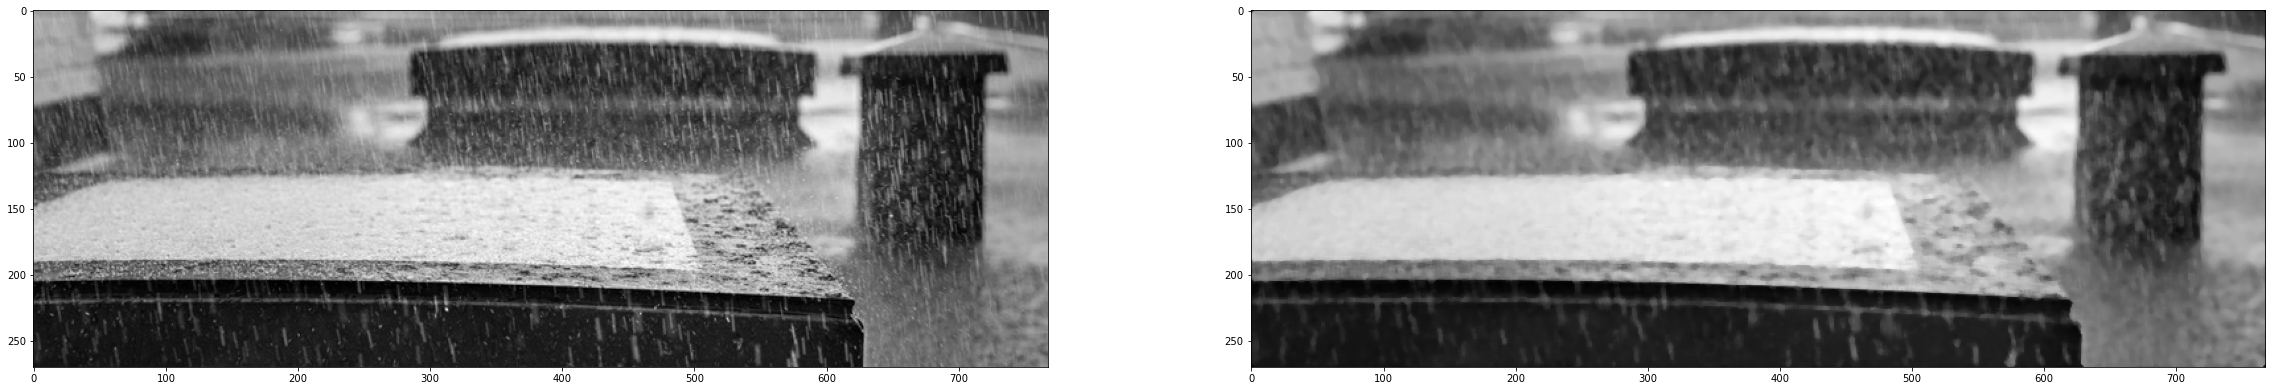

In [11]:
median_noise = noiseReductionMedianFilter(noise_1, 5)

f, axis = plt.subplots(1,2,figsize=(40,25))
axis[0].imshow(noise_1, cmap='gray')
axis[1].imshow(median_noise, cmap='gray')

In [12]:
def noiseReductionMeanFilter(img, n):
    """
    n : size of kernel
    """
    if n % 2 == 0:
        return "Kernel dimensions must be odd. "
    
    mean_kernel = np.zeros((n,n)).astype(float) + 1.0
    mean_kernel = mean_kernel * 1/(n*n)

    finalMatrix = convolvefilter(img, mean_kernel)
    return finalMatrix
    

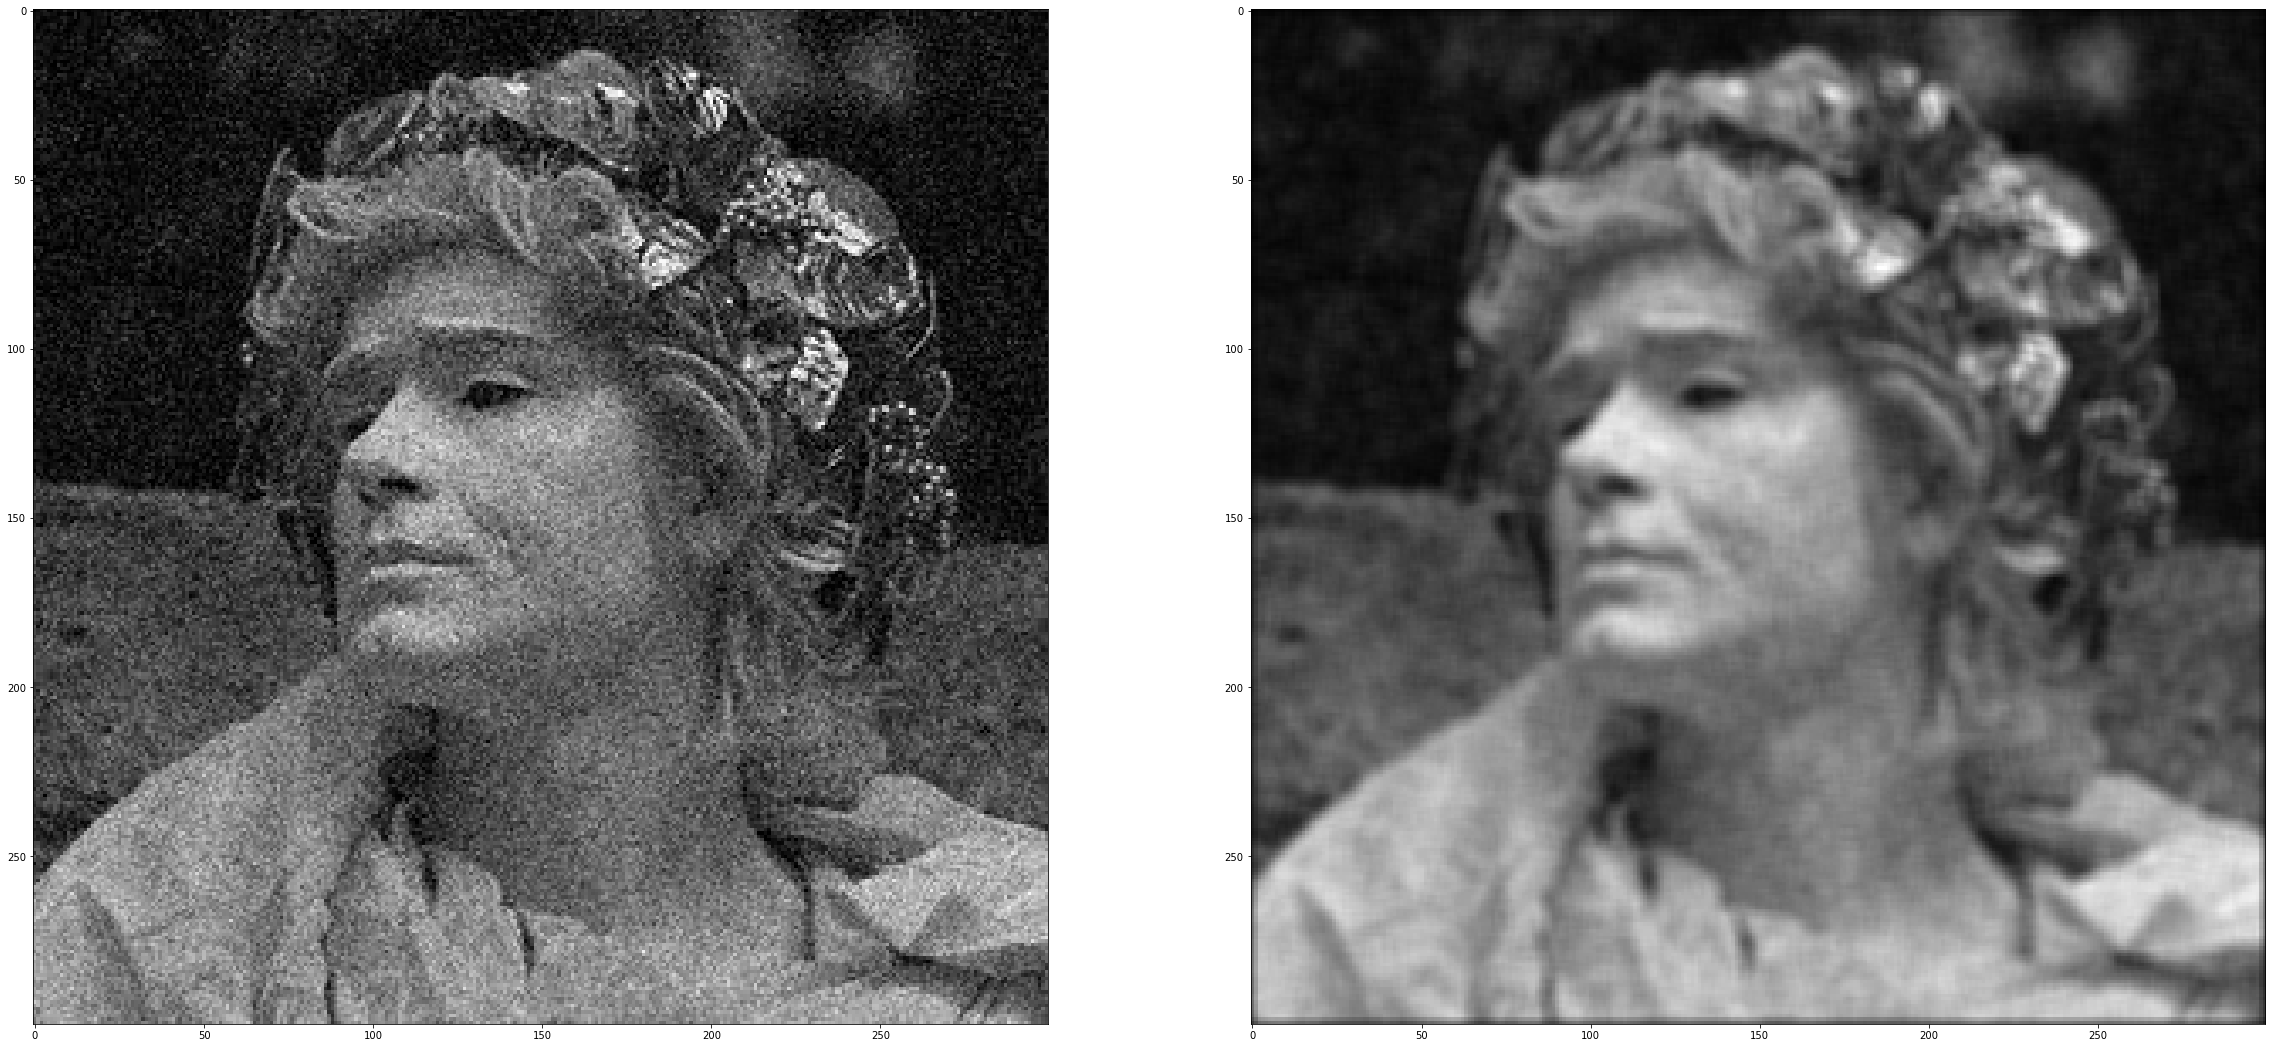

In [13]:
mean_noise = noiseReductionMeanFilter(noise_2, 5)

f, axis = plt.subplots(1,2,figsize=(40,25))
axis[0].imshow(noise_2, cmap='gray')
axis[1].imshow(mean_noise, cmap='gray')

# Questão 5
Filtro passa-alta : Obter detalhes de imagens

Imagens originais: img3, img4, im5


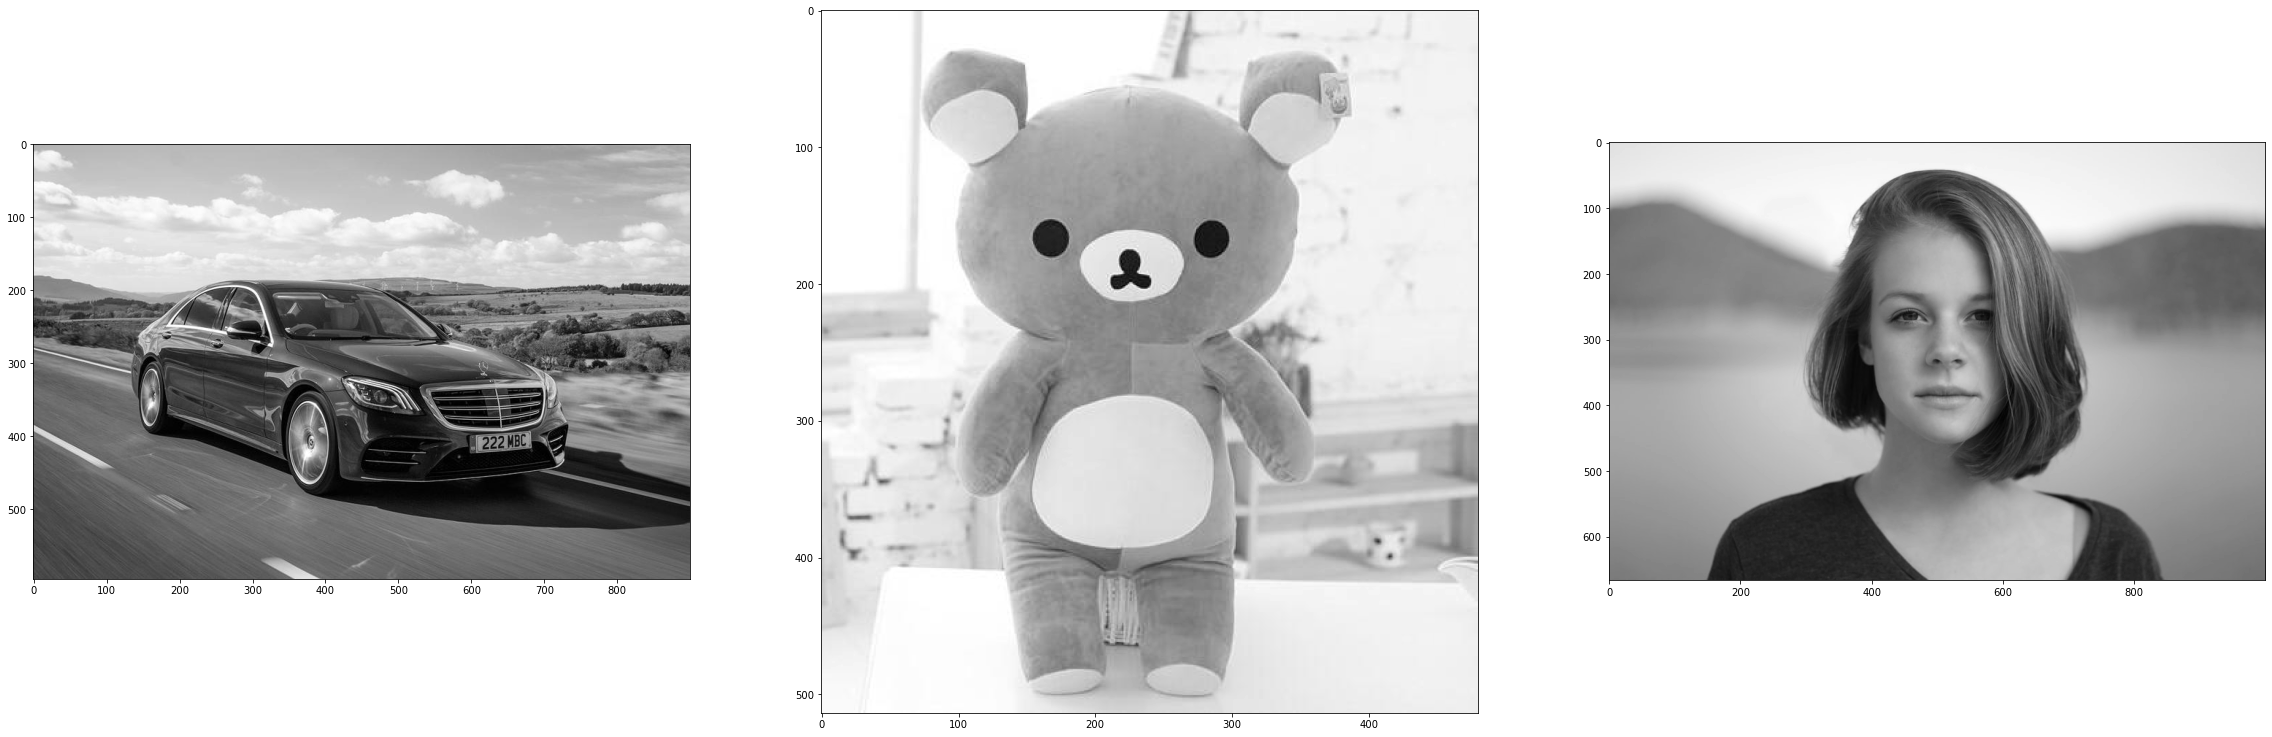

In [14]:
img3 = cv2.imread('imgs/car1.jpg', 0)
img4 = cv2.imread('imgs/bear.jpg', 0)
img5 = cv2.imread('imgs/person.jpg', 0)

print('Imagens originais: img3, img4, im5')

f, axis = plt.subplots(1,3,figsize=(40,25))
axis[0].imshow(img3, cmap='gray')
axis[1].imshow(img4, cmap='gray')
axis[2].imshow(img5, cmap='gray')


def highpassfilter(img, n):
    """
    n : size of kernel
    """
    # Normalizando os valores da imagem:
    img = img / 255
    
    blurred_img = noiseReductionMeanFilter(img, n)
    img_adapted = convolvefilter(img, np.ones((1,1)))
    
    finalMatrix = img_adapted - blurred_img
    return finalMatrix


# Com n = 5


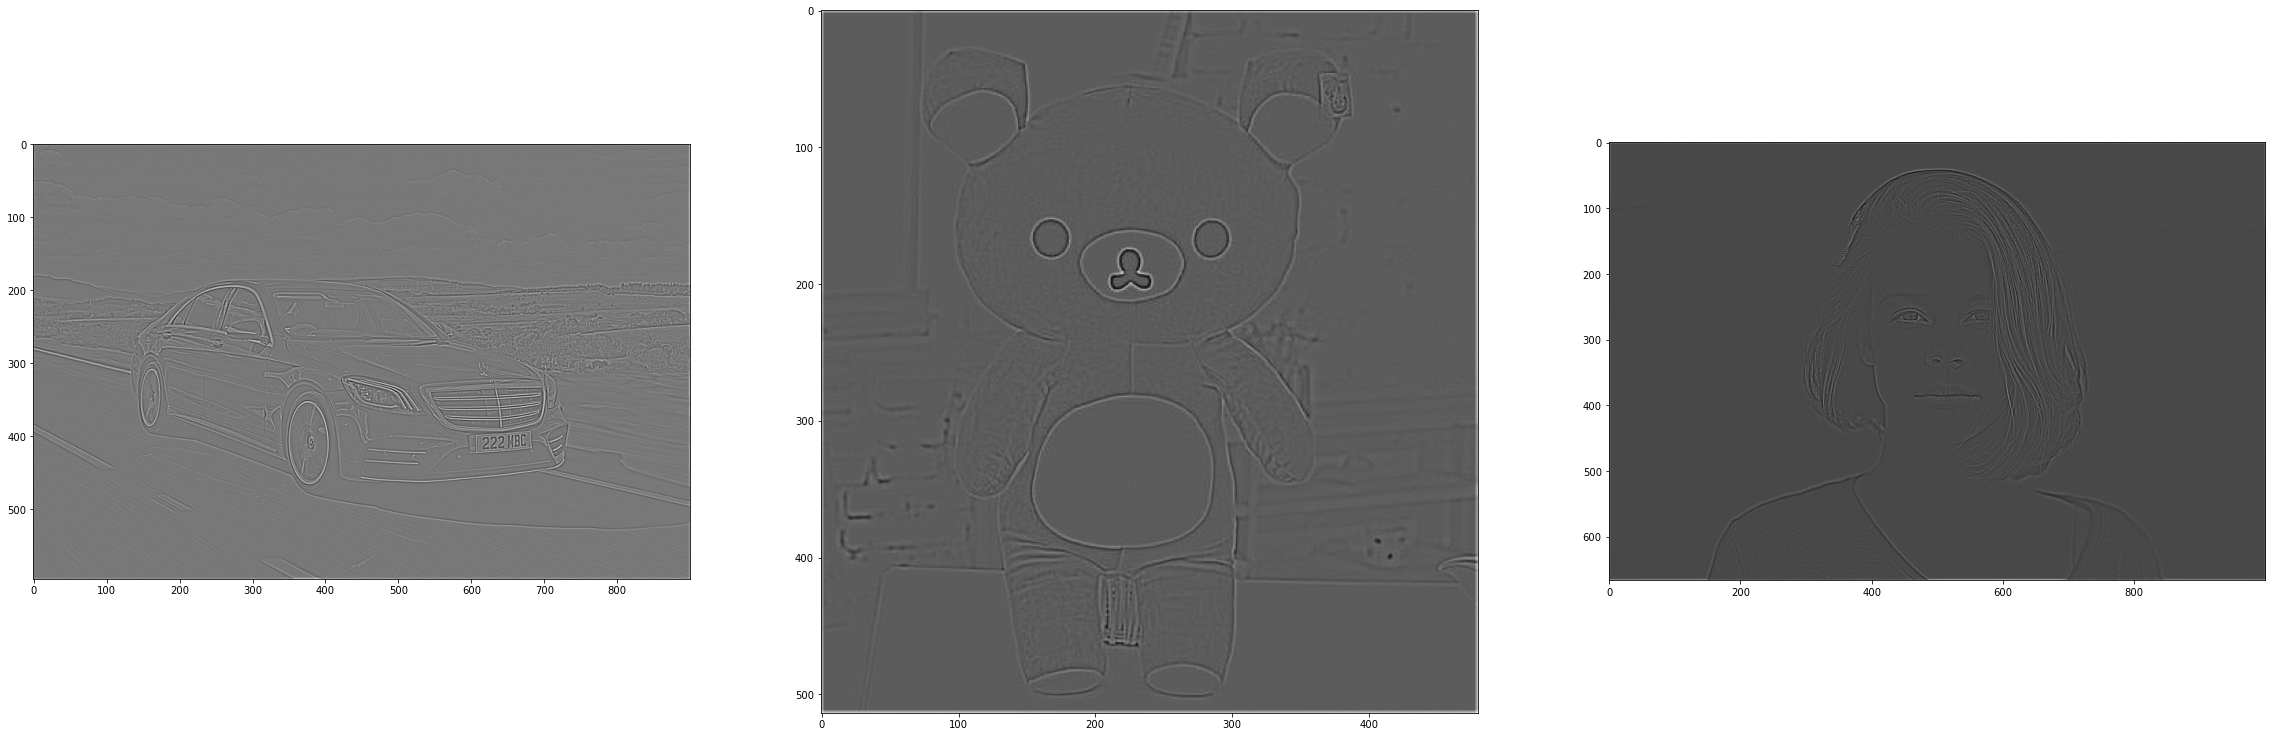

In [15]:
highpass_img3 = highpassfilter(img3, 5)
highpass_img4 = highpassfilter(img4, 5)
highpass_img5 = highpassfilter(img5, 5)



f, axis = plt.subplots(1,3,figsize=(40,25))
axis[0].imshow(highpass_img3, cmap='gray')
axis[1].imshow(highpass_img4, cmap='gray')
axis[2].imshow(highpass_img5, cmap='gray')


# Com n = 9, os detalhes ficam cada vez mais explícitos.

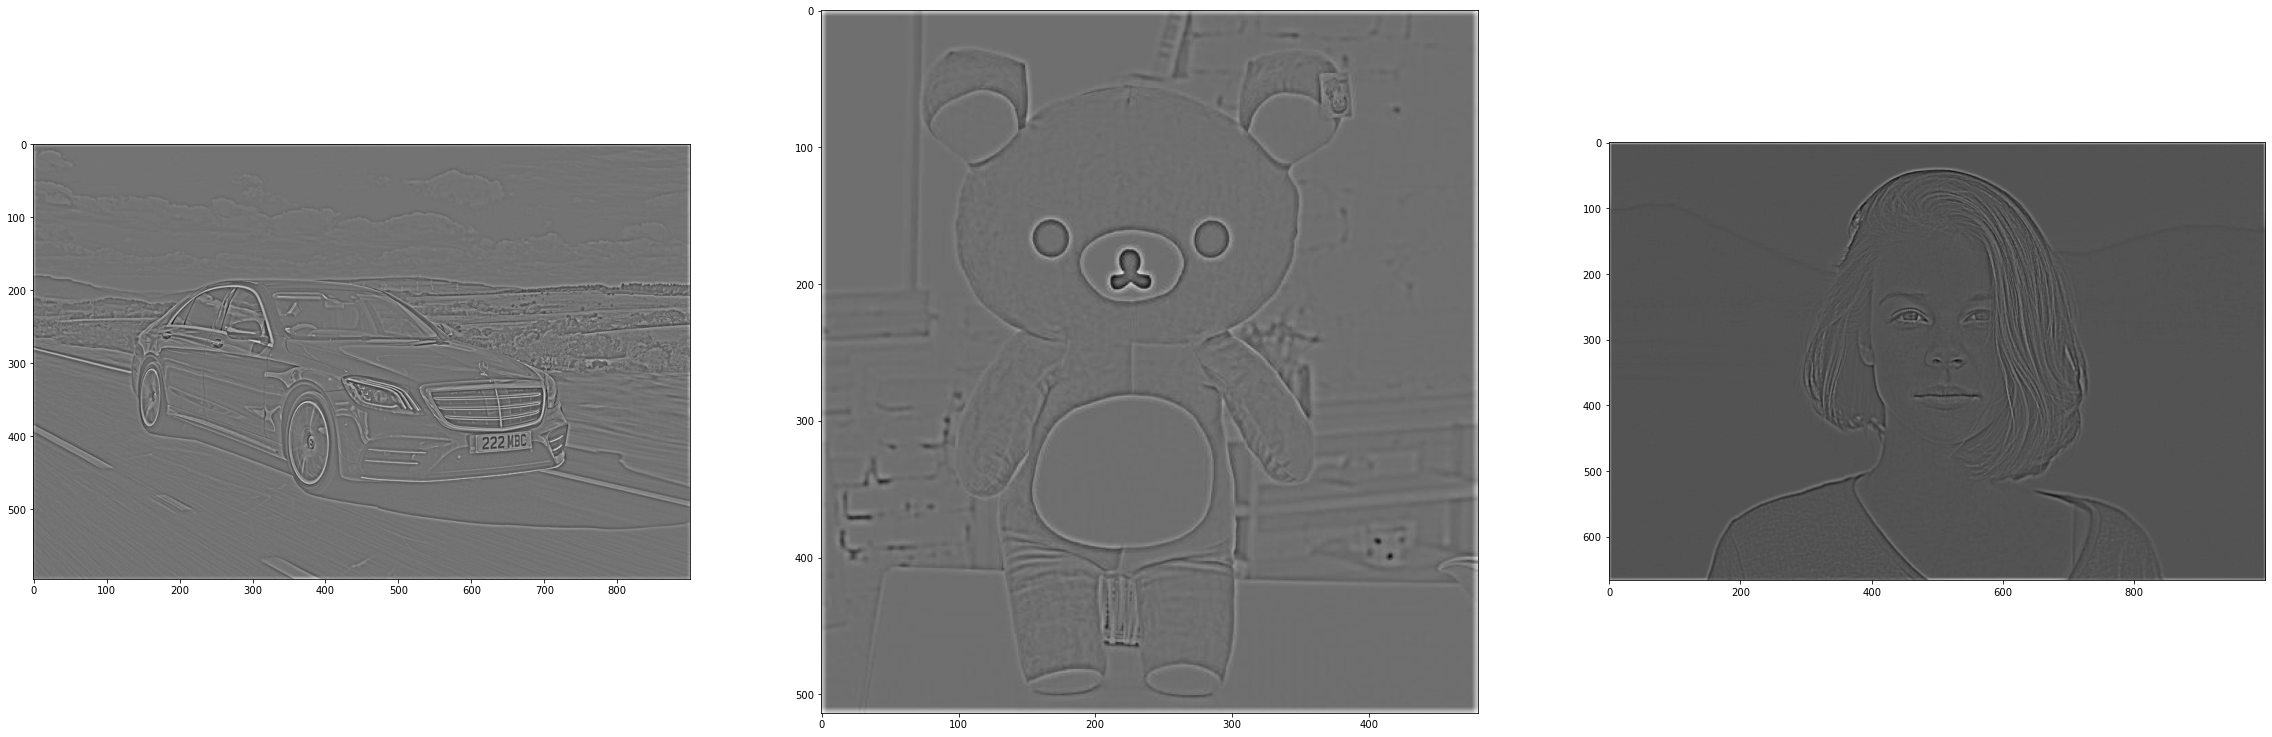

In [16]:
highpass_img3 = highpassfilter(img3, 9)
highpass_img4 = highpassfilter(img4, 9)
highpass_img5 = highpassfilter(img5, 9)



f, axis = plt.subplots(1,3,figsize=(40,25))
axis[0].imshow(highpass_img3, cmap='gray')
axis[1].imshow(highpass_img4, cmap='gray')
axis[2].imshow(highpass_img5, cmap='gray')


# Questão 6
Filtro passa-baixa: suavização de imagens

In [17]:
def lowpassfilter(img, n):
    """
    n : size of kernel
    """
    # Reutiliza-se a função de blur implementada anteriormente.
    finalMatrix = noiseReductionMeanFilter(img, n)
    
    return finalMatrix


# Com n = 5

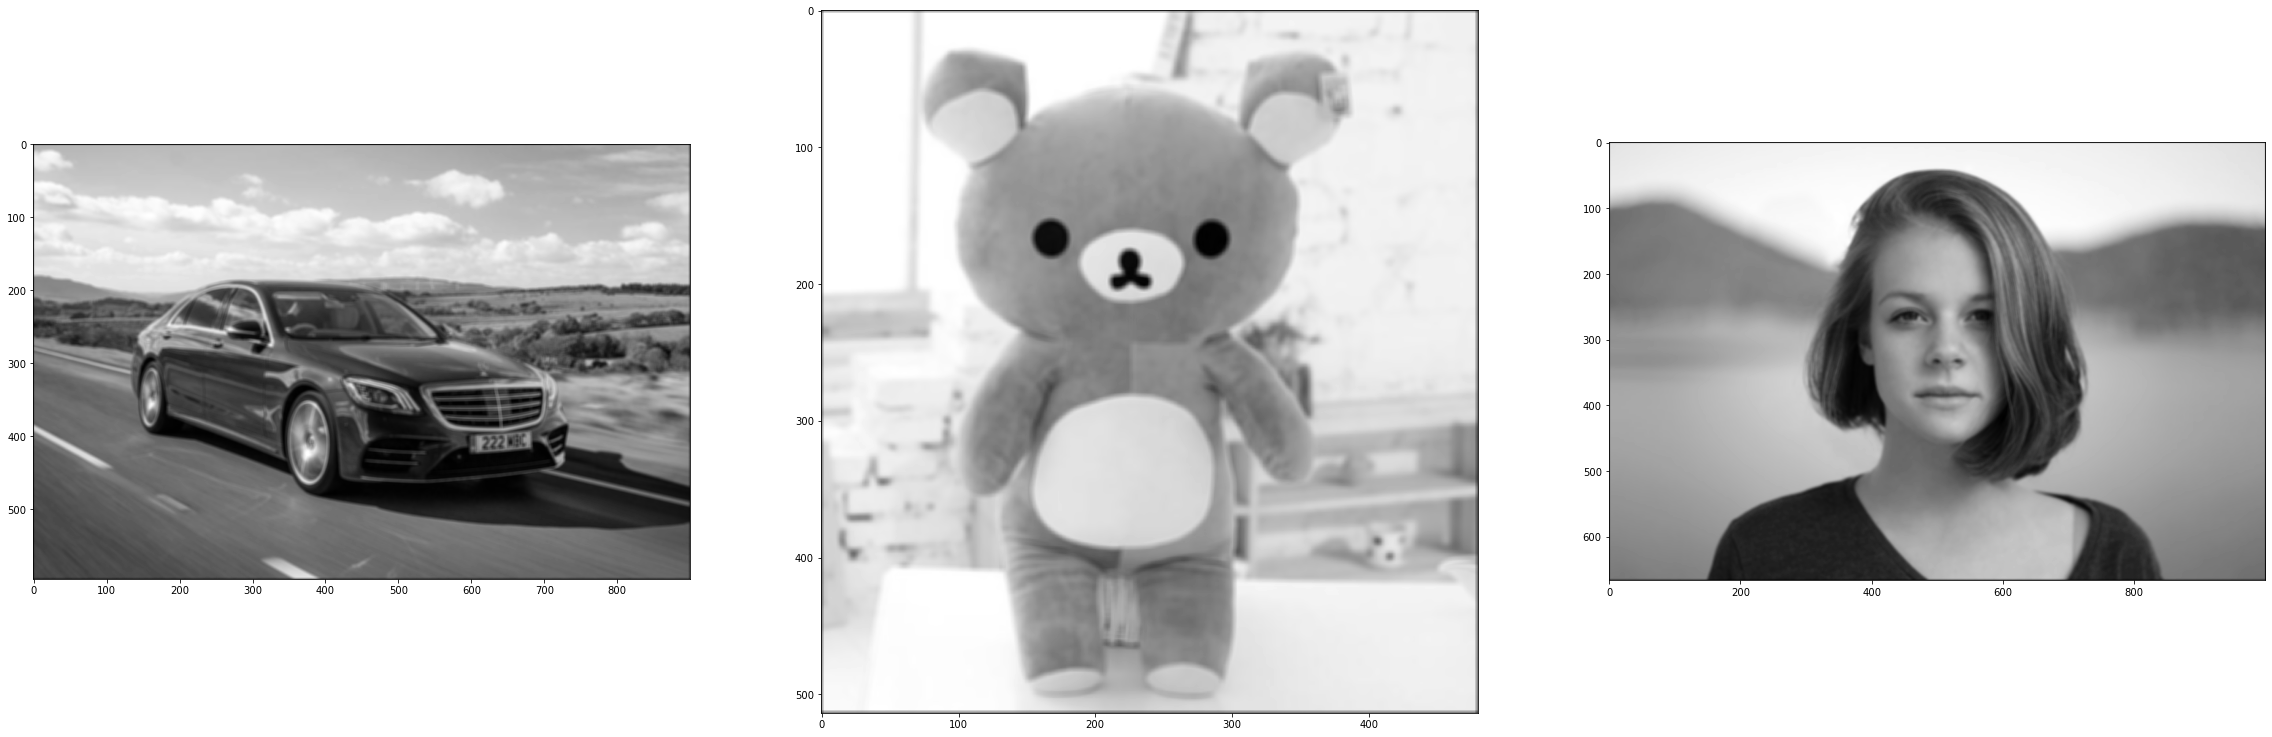

In [18]:
lowpass_img3 = lowpassfilter(img3, 5)
lowpass_img4 = lowpassfilter(img4, 5)
lowpass_img5 = lowpassfilter(img5, 5)



f, axis = plt.subplots(1,3,figsize=(40,25))
axis[0].imshow(lowpass_img3, cmap='gray')
axis[1].imshow(lowpass_img4, cmap='gray')
axis[2].imshow(lowpass_img5, cmap='gray')


# Com n = 9, a suavização na imagem fica mais intensa.

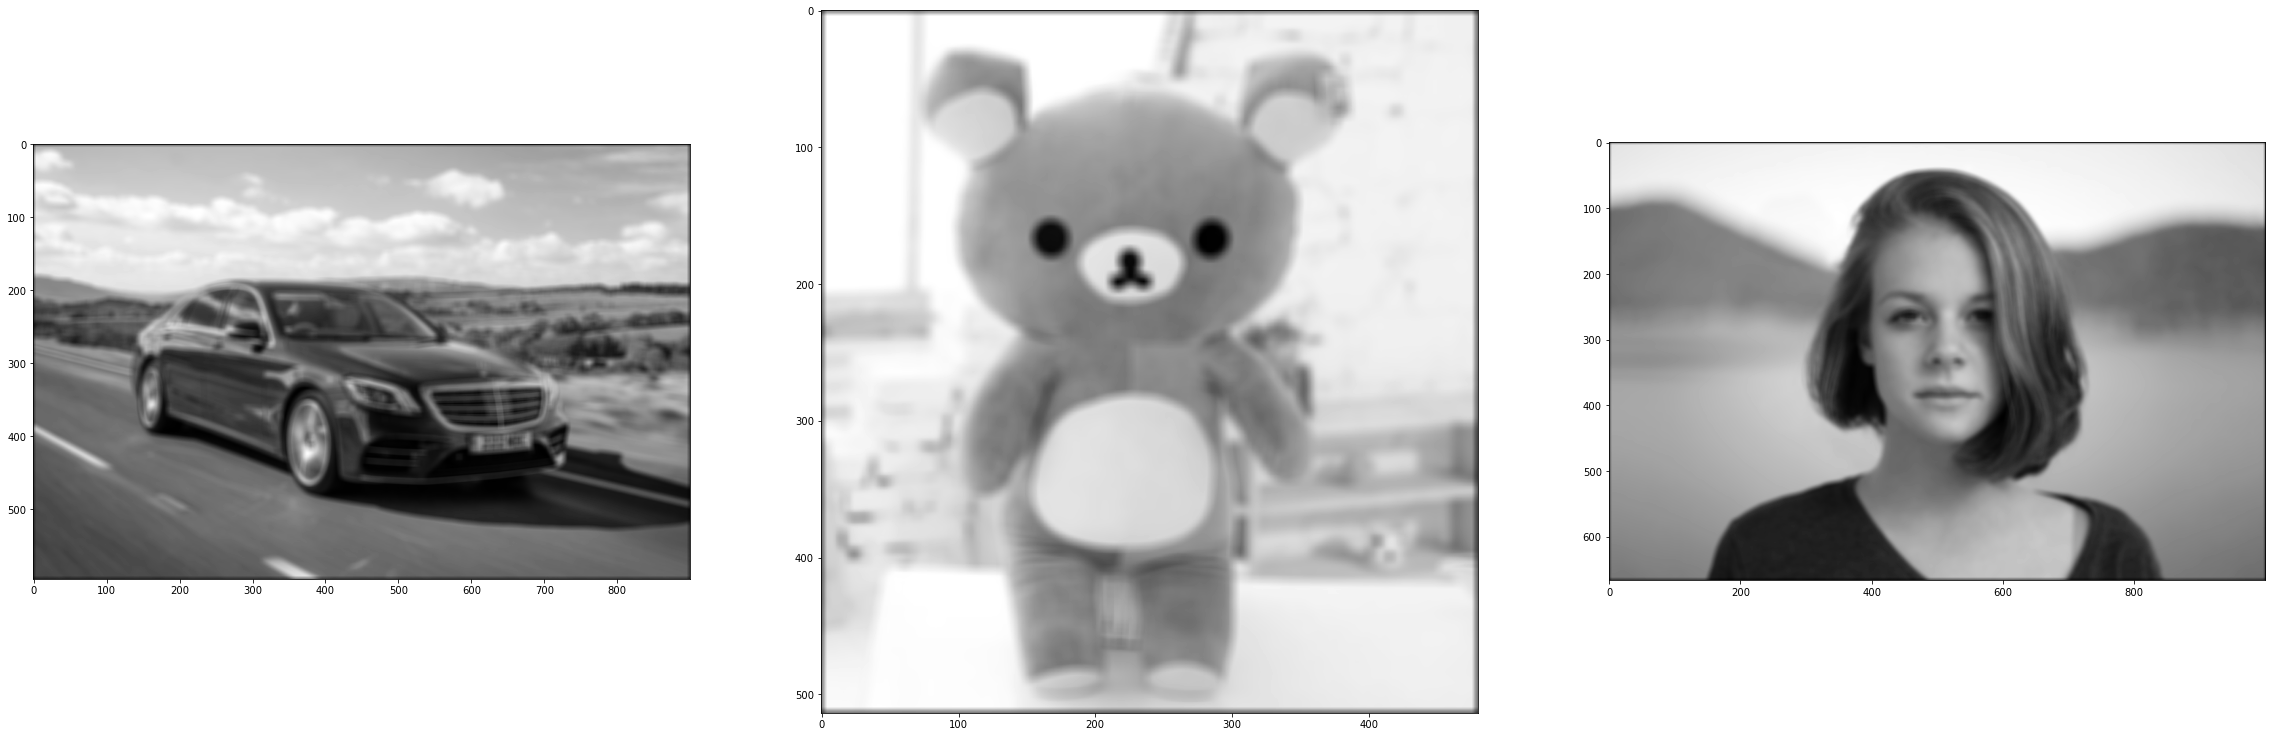

In [19]:
lowpass_img3 = lowpassfilter(img3, 9)
lowpass_img4 = lowpassfilter(img4, 9)
lowpass_img5 = lowpassfilter(img5, 9)



f, axis = plt.subplots(1,3,figsize=(40,25))
axis[0].imshow(lowpass_img3, cmap='gray')
axis[1].imshow(lowpass_img4, cmap='gray')
axis[2].imshow(lowpass_img5, cmap='gray')


# Questão 7
Extração de arestas

# Com n = 7

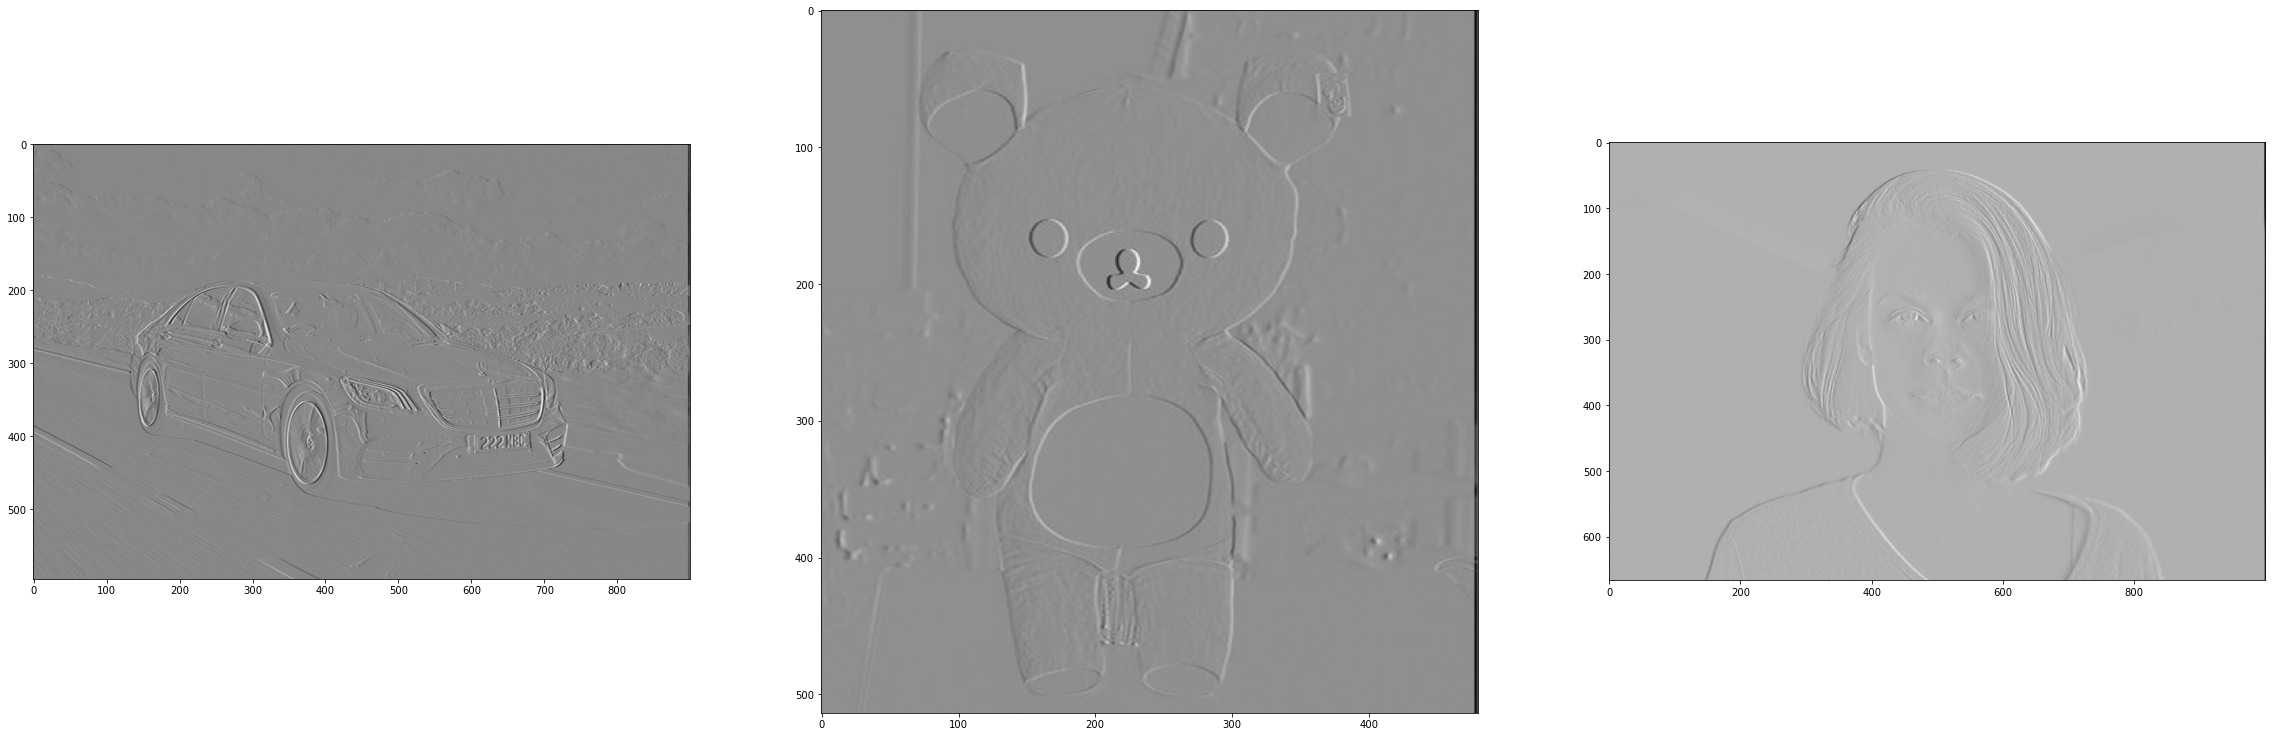

In [20]:
# Um kernel utilizado para conseguir a derivada d/dx de uma imagem:
kernel_dx7 = np.array([[0,0, 0, 0,0,0,0],
                       [0,0, 0, 0,0,0,0],
                       [0,0, 0, 0,0,0,0],
                       [2,2,-2,-2,0,0,0],
                       [0,0, 0, 0,0,0,0],
                       [0,0, 0, 0,0,0,0],
                       [0,0, 0, 0,0,0,0]])

edges_img3 = convolvefilter(img3, kernel_dx7)
edges_img4 = convolvefilter(img4, kernel_dx7)
edges_img5 = convolvefilter(img5, kernel_dx7)

f, axis = plt.subplots(1,3,figsize=(40,25))
axis[0].imshow(edges_img3, cmap='gray')
axis[1].imshow(edges_img4, cmap='gray')
axis[2].imshow(edges_img5, cmap='gray')

# Com n = 11, as arestas ficam mais explícitas

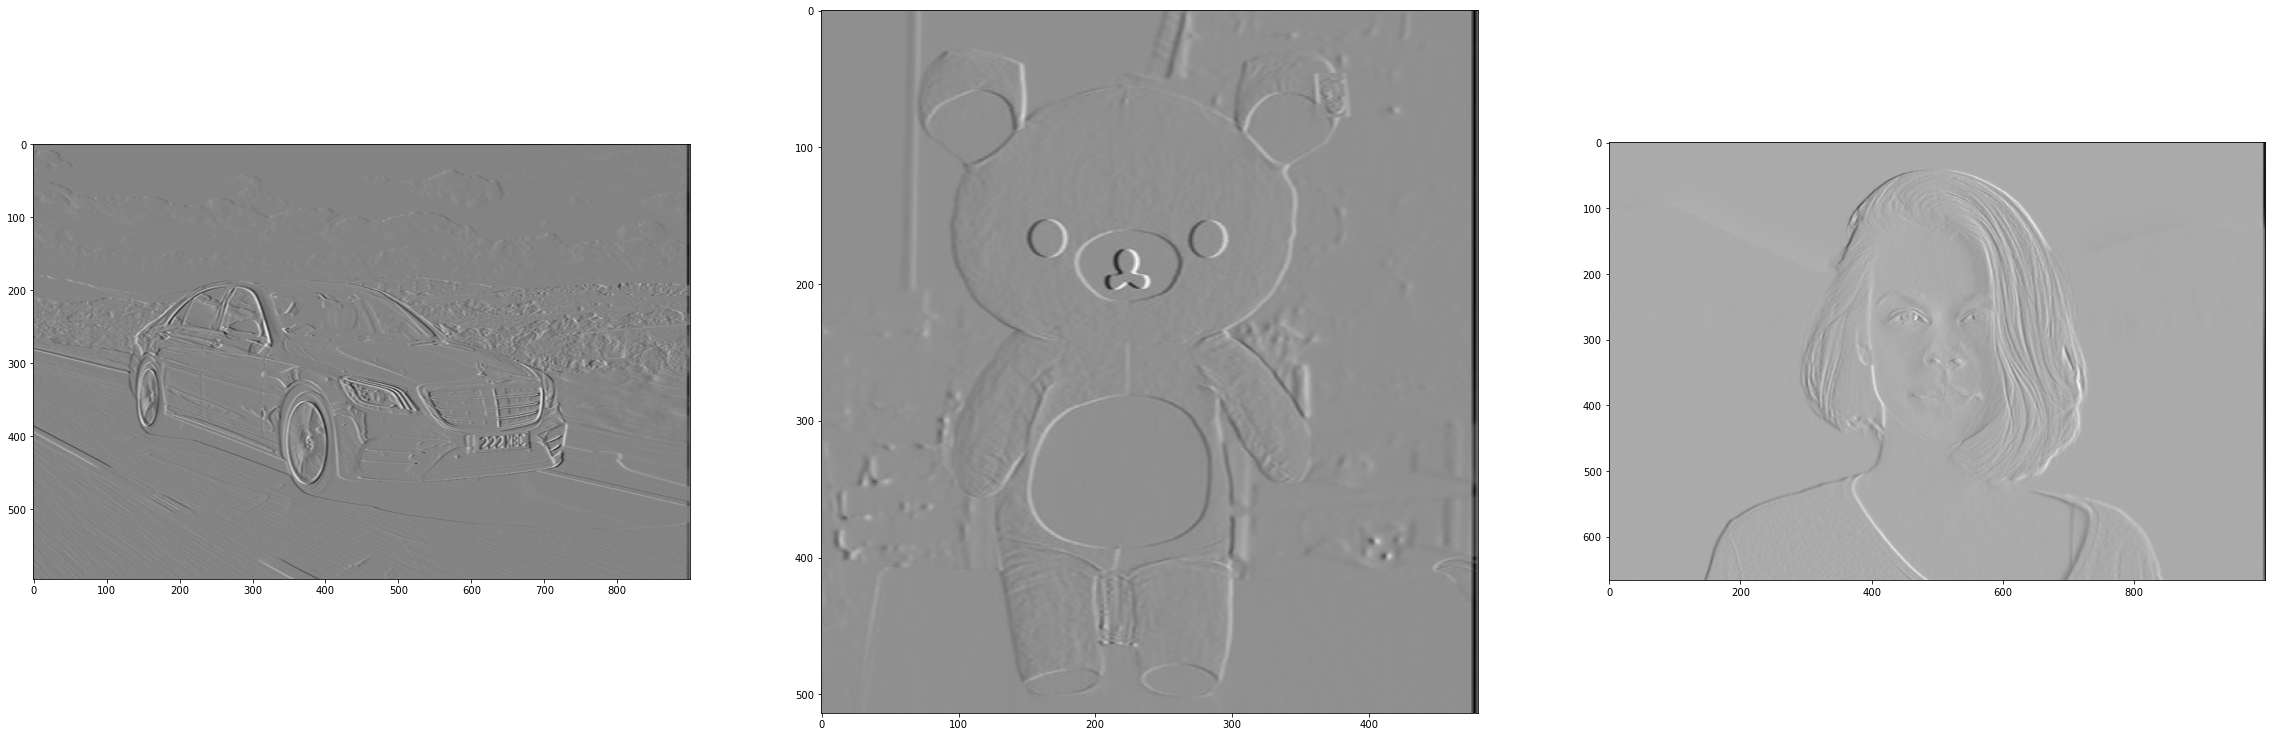

In [21]:
kernel_dx11 = np.array([
                       [0,0,0, 0, 0, 0,0,0,0,0,0],
                       [0,0,0, 0, 0, 0,0,0,0,0,0],
                       [0,0,0, 0, 0, 0,0,0,0,0,0],
                       [0,0,0, 0, 0, 0,0,0,0,0,0],
                       [0,0,0, 0, 0, 0,0,0,0,0,0],
                       [2,2,2,-2,-2,-2,0,0,0,0,0],
                       [0,0,0, 0, 0, 0,0,0,0,0,0],
                       [0,0,0, 0, 0, 0,0,0,0,0,0],
                       [0,0,0, 0, 0, 0,0,0,0,0,0],
                       [0,0,0, 0, 0, 0,0,0,0,0,0],
                       [0,0,0, 0, 0, 0,0,0,0,0,0]
                       ])
edges_img3_11 = convolvefilter(img3, kernel_dx11)
edges_img4_11 = convolvefilter(img4, kernel_dx11)
edges_img5_11 = convolvefilter(img5, kernel_dx11)

f, axis = plt.subplots(1,3,figsize=(40,25))
axis[0].imshow(edges_img3_11, cmap='gray')
axis[1].imshow(edges_img4_11, cmap='gray')
axis[2].imshow(edges_img5_11, cmap='gray')